In [7]:
import numpy as np
import pandas as pd
from numpy.random import normal as norm
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import random
%matplotlib inline

In [8]:
# for better simulations (be careful: 200 times longer)

# fixed biases [d-color, d-shape]
# -0.5 => green are perceived of having higher quality
# 1.5 => stars are perceived of having lower quality
d = [-0.5, 1.5]

# there are equal number of stars and circles i.e. N
# out of which f * N are green circles and (1 - f) * N are orange circles
# out of which f * N are orange stars and (1 - f) * N are green stars
# [f, (1 - f)]
f = [0.2, 0.8]

In [9]:
# Genetare biased distribution
# real quality q0 is from N(0, 1)
# d - discrimination against 1s
# f - fraction of indviduals having property having hidden (second) property
# N - number of people

def generate(d = [0.5, 0.5], f = [0.5, 0.5], N = [2000, 2000]):
    # size of groups
    s = [(1 - f[0]) * N[0], f[0] * N[0], (1 - f[1]) * N[1], f[1] * N[1]]
    s = [int(x) for x in s]

    # vector of properties
    a = [(0,0)] * s[0] + [(0,1)] * s[1] + [(1,0)] * s[2] + [(1,1)] * s[3]

    m = 0
    st = 1
    q0 = norm(m, st, len(a))

    # creating bias
    bias = [0 for i in range(s[0])] + [-d[1] * st for i in range(s[1])] + [-d[0] * st for i in range(s[2])] + [-d[1] * st - d[0] * st for i in range(s[3])]
    q = q0 + bias

    # shuffling the results
    rnd = [x for x in range(len(a))]
    random.shuffle(rnd)

    q = [q[i] for i in rnd]
    a = [a[i] for i in rnd]
    q0 = [q0[i] for i in rnd]

    # return vectors of properties, perceived qualities and real qualities
    return a, q, q0

def conv_to_df(a, q):
    data = list(zip(list(list(zip(*a))[0]), list(list(zip(*a))[1]), q))
    return pd.DataFrame(data, columns=['color', 'shape', 'perceived_quality'])

In [10]:
def generate_data(d, f):
    a, q, q0 = generate(d, f)
    df = conv_to_df(a, q)
    filename = 'temp_pre_pro.csv'
    repaired_filename = 'repaired_temp_pre_pro.csv'
    df.to_csv(filename)
    repair_command = "BlackBoxAuditing-repair {filename} {repaired_filename} 1 True -p 'color' -i 'shape'".format(filename=filename, repaired_filename=repaired_filename)
    !eval {repair_command}
    return df, pd.read_csv('repaired_temp_pre_pro.csv')[['color', 'shape', 'perceived_quality']]

In [11]:
# return individuals with top perceived qualities
def getTop(df, top = 0.1):
    df = df.sort_values(['perceived_quality'], ascending=[0])
    items = df[:int(df.shape[0] * top)]
    result = [(item['perceived_quality'], (int(item['color']), int(item['shape']))) for index, item in items.iterrows()]
    return result

In [12]:
# Compute chances to be in top k% for aggregated groups before and after debiasing
# d => fixed biases []
# f => number of elements
def get_aggregated(d, f, Nsim, k_range):
    results = {'original': {0: [], 1: [], 'data': []},
               'debiased': {0: [], 1: [], 'data': []}}


    # shapes(invisible) => 0: circle; 1: stars
    # colors(visible) => 0: orange; 1: green
    groups = [0, 1]

    for k in k_range:
        simulations = {'original': {0: [], 1: [], 'data': []},
                       'debiased': {0: [], 1: [], 'data': []}}

        for i in tqdm(range(0, Nsim), desc='Simulations for Top {}'.format(k*100)):
            data, data_repaired = generate_data(d, f)

            for group in groups:

                # compute expected chances to be in top
                exp = data[(data['color'] == group)].shape[0] / data.shape[0]

                for approach in ['original', 'debiased']:

                    if approach == 'original':
                        df = data
                    else:
                        df = data_repaired

                    top = getTop(df, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)

                    simulations[approach][group].append((real - exp) / exp)
                    simulations[approach]['data'].append(df)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
                results[approach]['data'] = simulations[approach]['data']
    return results

In [13]:
def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}
    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])

    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [20]:
# for quick results
Nsim = 5

# to fetch top k% candidates
k_range = [i / 100 for i in range(1, 101, 5)]

Simulations for Top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

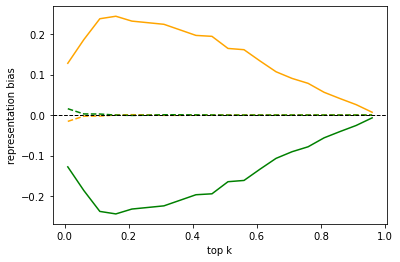

In [21]:
results = get_aggregated(d, f, Nsim, k_range)
plot_aggregated(results)

In [22]:
# Compute chances to be in top k% for disaggregated groups before and after debiasing
def get_disaggregated(d, f, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]

    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}

        for i in tqdm(range(0, Nsim), desc='Simulations for Top {}'.format(k*100)):
            data, data_repaired = generate_data(d, f)

            for g in groups:
                # compute expected chances to be in top
                exp = data[(data['color'] == g[0]) & (data['shape'] == g[1])].shape[0] / data.shape[0]

                for approach in ['original', 'debiased']:
                    if approach == 'original':
                        df = data
                    else:
                        df = data_repaired

                    top = getTop(df, k)

                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    for g in groups:
        for approach in ['original', 'debiased']:
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])

    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.fill_between(k_range, results['debiased'][(0,1)], results['original'][(0,1)], color='orange', alpha=.25)

    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [23]:
results_diss = get_disaggregated(d, f, Nsim, k_range)
plot_disaggregated(results_diss)

Simulations for Top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for Top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
np.save('results_pre_synth.npy', {'agg': results, 'diss_agg': results_diss})

In [27]:
read_dictionary = np.load('results_pre_synth.npy', allow_pickle='TRUE').item()
read_dictionary

{'agg': {'original': {0: [0.12792307692307686,
    0.1863142259414224,
    0.23795922551252838,
    0.24413333333333323,
    0.23211144219308685,
    0.22818180943214622,
    0.22422978208232439,
    0.210538151494093,
    0.19677211714460024,
    0.1944810766721043,
    0.164593526238352,
    0.16147820455560508,
    0.13362386223862235,
    0.10696078059871153,
    0.09053392039450506,
    0.07837462981243827,
    0.056234794689718995,
    0.04062375690607728,
    0.025739653751030423,
    0.006885491013284663],
   1: [-0.1279870704583061,
    -0.18640742965625073,
    -0.23807826464485093,
    -0.24425546106386528,
    -0.2322275559710726,
    -0.22829595741085176,
    -0.2243419530588539,
    -0.21064347323070848,
    -0.1968705524208108,
    -0.19457836585503197,
    -0.1646758641704374,
    -0.16155898404762903,
    -0.1336907075924186,
    -0.10701428774258297,
    -0.09057920999950489,
    -0.07841383673080375,
    -0.05626292615279551,
    -0.040644078945550145,
    -0.0257525